In [1]:
# common recipe to get access to the source inside src
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
##########################################################

import numpy as np
from pathlib import Path

from models.CaptionModalityClassifier import CaptionModalityClassifier # caption modality classifier
from dataset.MultilabelDataModule import MultilabelDataModule       # pytorch lightning data module for captions and images
from utils.caption_utils import load_glove_matrix                      # utils for embeddings

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

from dataset.utils import clean_str

In [8]:
batch_size = 32
csv_path = '/workspace/data/microscopy_captions_multilabel_kfolds.csv'
max_length_size = 200
num_workers = 72
random_state = 443

dm = MultilabelDataModule(batch_size,
                            csv_path,
                            20000,
                            max_length_size,
                            num_workers=num_workers,
                            random_state=random_state,
                            kfold_col='KFOLD_MULTI',
                            preprocess_fn=clean_str)
dm.prepare_data()
dm.setup(k_fold_idx=0)

In [29]:
df_train = dm.train_dataloader().dataset.df
df_valid = dm.val_dataloader().dataset.df
df.head()

,CAPTION,DMFL,DMTR,DMEL,DMLI,SET,ID,KFOLD,KFOLD_MULTI,PR_CAPTION
0,Microscopic specimen of resected spleen with t...,0,0,0,1,TRAIN,467,0,1,microscopic specimen resected spleen character...
1,Imaging features of osteosarcoma. Panel A is a...,0,0,1,0,TRAIN,340,0,4,imaging features osteosarcoma panel plain radi...
2,ESEM spot analyses of potential catalyst sites...,0,1,1,1,TRAIN,186,3,3,esem spot analyses potential catalyst sites ol...
3,Human placenta obtained at 23 weeks gestation ...,0,0,0,1,TRAIN,329,0,4,human placenta 23 weeks gestation stained anti...
4,slightly thickened blood vessels in the red pu...,0,0,0,1,TRAIN,815,0,1,slightly thickened blood vessels red pulp


In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [223]:
def get_training_data(kfold):
    dm.setup(k_fold_idx=kfold)
    df_train = dm.train_dataloader().dataset.df
    df_valid = dm.val_dataloader().dataset.df
    
    tfv = TfidfVectorizer(ngram_range=(1,4))
    tfv.fit(df_train.PR_CAPTION.values)
    
    cols = ['DMEL', 'DMFL', 'DMLI', 'DMTR']
    xtrain = tfv.transform(df_train.PR_CAPTION.values)
    xvalid = tfv.transform(df_valid.PR_CAPTION.values)
    ytrain = df_train[cols].values
    yvalid = df_valid[cols].values
    return xtrain, xvalid, ytrain, yvalid

def get_training_data_count(kfold):
    dm.setup(k_fold_idx=kfold)
    df_train = dm.train_dataloader().dataset.df
    df_valid = dm.val_dataloader().dataset.df
    
    tfv = CountVectorizer(ngram_range=(1, 3))
    tfv.fit(df_train.PR_CAPTION.values)
    
    cols = ['DMEL', 'DMFL', 'DMLI', 'DMTR']
    xtrain = tfv.transform(df_train.PR_CAPTION.values)
    xvalid = tfv.transform(df_valid.PR_CAPTION.values)
    ytrain = df_train[cols].values
    yvalid = df_valid[cols].values
    return xtrain, xvalid, ytrain, yvalid

def print_num_lbls(ypred):
    num_preds   = np.sum(ypred, axis=1)
    count_zero  = np.sum(num_preds == 0)
    count_one   = np.sum(num_preds == 1)
    count_two   = np.sum(num_preds == 2)
    count_three = np.sum(num_preds == 3)
    count_four  = np.sum(num_preds == 4)
    print(f"\t0:{count_zero}\t 1:{count_one}\t 2:{count_two}\t 3:{count_three}\t 4:{count_four}\t total:{num_preds.shape[0]}")
    
def plot_hyperplane(clf, min_x, max_x, linestyle, label):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, linestyle, label=label)
    
def plot_subfigure(X, Y, Xvalid, Yvalid, subplot, title, transform, clf):
    if transform == "pca":
        pca = PCA(n_components=2) 
        X = pca.fit_transform(X)
        Xvalid = pca.transform(Xvalid)
    elif transform == "cca":
        cca  = CCA(n_components=2)
        X = cca.fit(X, Y).transform(X)
        Xvalid = cca.transform(Xvalid)
    else:
        raise ValueError

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])    
    
    clf.fit(X, Y)
    
    plt.subplot(5, 1, subplot)    

    dmel_class = np.where(Y[:, 0])
    dmfl_class = np.where(Y[:, 1])
    dmli_class = np.where(Y[:, 2])
    dmtr_class = np.where(Y[:, 3])
    
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray', edgecolors=(0, 0, 0))
    plt.scatter(X[dmel_class, 0], X[dmel_class, 1], s=160, edgecolors='#984ea3',
                facecolors='none', linewidths=2, label='DMEL')
    plt.scatter(X[dmfl_class, 0], X[dmfl_class, 1], s=80, edgecolors='#4daf4a',
                facecolors='none', linewidths=2, label='DMFL')
    plt.scatter(X[dmli_class, 0], X[dmli_class, 1], s=50, edgecolors='#377eb8',
                facecolors='none', linewidths=2, label='DMLI')
    plt.scatter(X[dmtr_class, 0], X[dmtr_class, 1], s=20, edgecolors='#e41a1c',
                facecolors='none', linewidths=2, label='DMTR')

    plot_hyperplane(clf.estimators_[0], min_x, max_x, 'k-', 'Boundary DMEL')
    plot_hyperplane(clf.estimators_[1], min_x, max_x, 'k--', 'Boundary DMFL')
    plot_hyperplane(clf.estimators_[2], min_x, max_x, 'k-.', 'Boundary DMLI')
    plot_hyperplane(clf.estimators_[3], min_x, max_x, 'k-', 'Boundary DMTR')
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)
#     if subplot == 2:

    ypred = clf.predict(Xvalid)
    avg_prec = average_precision_score(Yvalid, ypred, average='macro')
    plt.title(f"{title} ({avg_prec})")

    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend(loc="lower right")

In [31]:
cols = ['DMEL', 'DMFL', 'DMLI', 'DMTR']
xtrain = tfv.transform(df_train.PR_CAPTION.values)
xvalid = tfv.transform(df_valid.PR_CAPTION.values)
ytrain = df_train[cols].values
yvalid = df_valid[cols].values
xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape

((656, 6853), (165, 6853), (656, 4), (165, 4))

# Use TFIDF as features

In [224]:
clf = OneVsRestClassifier(SVC(kernel='linear'))
averages = []
for k in range(5):
    xtrain, xvalid, ytrain, yvalid = get_training_data(k)
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xvalid)
    avg_prec = average_precision_score(yvalid, ypred > 0.5, average='macro')
    averages.append(avg_prec)
    print(f"fold: {k}, average_precision: {avg_prec}")
    print_num_lbls(ypred)
print(f"average: {np.mean(np.array(averages))}")

fold: 0, average_precision: 0.566045131588675
	0:28	 1:129	 2:8	 3:0	 4:0	 total:165
fold: 1, average_precision: 0.6051853490291406
	0:28	 1:132	 2:7	 3:0	 4:0	 total:167
fold: 2, average_precision: 0.5971782718201436
	0:26	 1:127	 2:7	 3:0	 4:0	 total:160
fold: 3, average_precision: 0.5624020112383654
	0:45	 1:115	 2:2	 3:0	 4:0	 total:162
fold: 4, average_precision: 0.5920197462188569
	0:26	 1:136	 2:5	 3:0	 4:0	 total:167
average: 0.5845661019790362


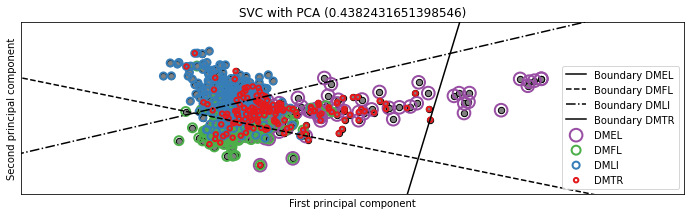

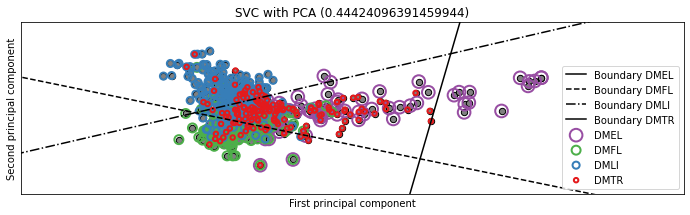

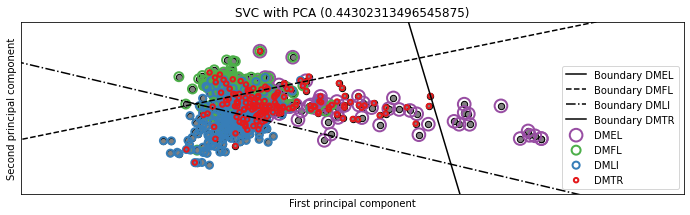

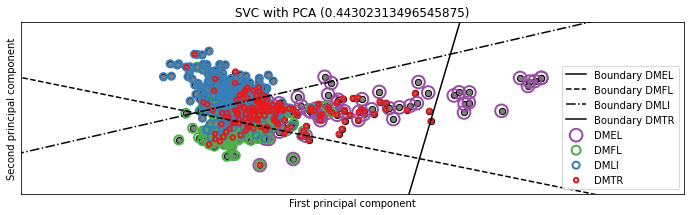

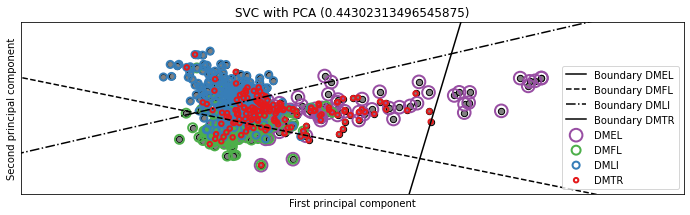

In [208]:
for k in range(5):
    clf = OneVsRestClassifier(SVC(kernel='linear'))
    plt.figure(figsize=(10, 15))
    plot_subfigure(xtrain.todense(), ytrain, xvalid.todense(), yvalid, k+1, "SVC with PCA", "pca", clf)
    plt.subplots_adjust(.05, .02, .97, .94, .09, .2)

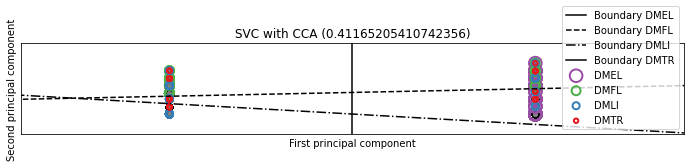

In [210]:
plt.figure(figsize=(10, 8))
plot_subfigure(xtrain.todense(), ytrain, xvalid.todense(), yvalid, k+1, "SVC with CCA", "cca", clf)
plt.subplots_adjust(.05, .02, .97, .94, .09, .2)

In [98]:
clf = OneVsRestClassifier(SVC(kernel='rbf'))
averages = []
for k in range(5):
    xtrain, xvalid, ytrain, yvalid = get_training_data(k)
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xvalid)
    avg_prec = average_precision_score(yvalid, ypred > 0.5, average='macro')
    averages.append(avg_prec)
    print(f"fold: {k}, average_precision: {avg_prec}")
    print_num_lbls(ypred)
print(f"average: {np.mean(np.array(averages))}")

fold: 0, average_precision: 0.5074003179584674
	0:72	 1:93	 2:0	 3:0	 4:0	 total:165
fold: 1, average_precision: 0.5233020509337547
	0:71	 1:96	 2:0	 3:0	 4:0	 total:167
fold: 2, average_precision: 0.5426723893325124
	0:61	 1:98	 2:1	 3:0	 4:0	 total:160
fold: 3, average_precision: 0.5082121857634432
	0:71	 1:90	 2:1	 3:0	 4:0	 total:162
fold: 4, average_precision: 0.529552207179271
	0:69	 1:97	 2:1	 3:0	 4:0	 total:167
average: 0.5222278302334897


In [95]:
clf = DecisionTreeClassifier(random_state=random_state)
averages = []
for k in range(5):
    xtrain, xvalid, ytrain, yvalid = get_training_data(k)
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xvalid)
    avg_prec = average_precision_score(yvalid, ypred > 0.5, average='macro')
    averages.append(avg_prec)
    print(f"fold: {k}, average_precision: {avg_prec}")
    print_num_lbls(ypred)
print(f"average: {np.mean(np.array(averages))}")

fold: 0, average_precision: 0.4525213734891155
	0:0	 1:153	 2:11	 3:1	 4:0	 total:165
fold: 1, average_precision: 0.48522353120678985
	0:0	 1:151	 2:12	 3:4	 4:0	 total:167
fold: 2, average_precision: 0.4896694294015887
	0:0	 1:134	 2:21	 3:3	 4:2	 total:160
fold: 3, average_precision: 0.4779008617063836
	0:0	 1:146	 2:16	 3:0	 4:0	 total:162
fold: 4, average_precision: 0.48833219896524366
	0:0	 1:149	 2:18	 3:0	 4:0	 total:167
average: 0.4787294789538243


In [96]:
clf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
averages = []
for k in range(5):
    xtrain, xvalid, ytrain, yvalid = get_training_data(k)
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xvalid)
    avg_prec = average_precision_score(yvalid, ypred > 0.5, average='macro')
    averages.append(avg_prec)
    print(f"fold: {k}, average_precision: {avg_prec}")
    print_num_lbls(ypred)
print(f"average: {np.mean(np.array(averages))}")

fold: 0, average_precision: 0.5626807966806148
	0:28	 1:136	 2:1	 3:0	 4:0	 total:165
fold: 1, average_precision: 0.5910691693419741
	0:30	 1:137	 2:0	 3:0	 4:0	 total:167
fold: 2, average_precision: 0.5843864220798825
	0:29	 1:131	 2:0	 3:0	 4:0	 total:160
fold: 3, average_precision: 0.559699516670431
	0:27	 1:135	 2:0	 3:0	 4:0	 total:162
fold: 4, average_precision: 0.5687038441844167
	0:40	 1:127	 2:0	 3:0	 4:0	 total:167
average: 0.5733079497914638


In [97]:
for nb in [3, 5, 7]:
    print(f"knn: {nb}")
    averages = []
    for k in range(5):
        neigh = KNeighborsClassifier(n_neighbors=nb)
        xtrain, xvalid, ytrain, yvalid = get_training_data(k)    
        neigh.fit(xtrain, ytrain)
        ypred = neigh.predict(xvalid)
        avg_prec = average_precision_score(yvalid, ypred > 0.5, average='macro')
        averages.append(avg_prec)
        print(f"fold: {k}, average_precision: {avg_prec}")
        print_num_lbls(ypred)
    print(f"average: {np.mean(np.array(averages))}")
    print()

knn: 3
fold: 0, average_precision: 0.5024913243847786
	0:17	 1:129	 2:18	 3:1	 4:0	 total:165
fold: 1, average_precision: 0.47264641211197234
	0:7	 1:130	 2:27	 3:3	 4:0	 total:167
fold: 2, average_precision: 0.5010358162294158
	0:16	 1:122	 2:20	 3:2	 4:0	 total:160
fold: 3, average_precision: 0.4836612557812512
	0:13	 1:130	 2:18	 3:1	 4:0	 total:162
fold: 4, average_precision: 0.47283587941585975
	0:7	 1:139	 2:20	 3:1	 4:0	 total:167
average: 0.4865341375846556

knn: 5
fold: 0, average_precision: 0.477211158182508
	0:16	 1:134	 2:14	 3:1	 4:0	 total:165
fold: 1, average_precision: 0.5060115035147824
	0:17	 1:130	 2:19	 3:1	 4:0	 total:167
fold: 2, average_precision: 0.49875690278179097
	0:17	 1:126	 2:16	 3:1	 4:0	 total:160
fold: 3, average_precision: 0.5142674637699838
	0:20	 1:132	 2:9	 3:1	 4:0	 total:162
fold: 4, average_precision: 0.4730125978497058
	0:18	 1:130	 2:19	 3:0	 4:0	 total:167
average: 0.49385192521975413

knn: 7
fold: 0, average_precision: 0.5046628263110438
	0:2

In [100]:
clf = MLPClassifier(random_state=random_state)
averages = []
for k in range(5):
    xtrain, xvalid, ytrain, yvalid = get_training_data(k)
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xvalid)
    avg_prec = average_precision_score(yvalid, ypred > 0.5, average='macro')
    averages.append(avg_prec)
    print(f"fold: {k}, average_precision: {avg_prec}")
    print_num_lbls(ypred)
print(f"average: {np.mean(np.array(averages))}")

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


fold: 0, average_precision: 0.5716168030081817
	0:35	 1:123	 2:7	 3:0	 4:0	 total:165


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


fold: 1, average_precision: 0.5335426733140123
	0:32	 1:124	 2:11	 3:0	 4:0	 total:167


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


fold: 2, average_precision: 0.5601930600935803
	0:22	 1:129	 2:9	 3:0	 4:0	 total:160


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


fold: 3, average_precision: 0.5550270320033317
	0:34	 1:118	 2:10	 3:0	 4:0	 total:162
fold: 4, average_precision: 0.5216898894625576
	0:23	 1:126	 2:18	 3:0	 4:0	 total:167
average: 0.5484138915763327


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Using CountVectorizer

In [217]:
clf = OneVsRestClassifier(SVC(kernel='linear'))
averages = []
for k in range(5):
    xtrain, xvalid, ytrain, yvalid = get_training_data_count(k)
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xvalid)
    avg_prec = average_precision_score(yvalid, ypred > 0.5, average='macro')
    averages.append(avg_prec)
    print(f"fold: {k}, average_precision: {avg_prec}")
    print_num_lbls(ypred)
print(f"average: {np.mean(np.array(averages))}")

fold: 0, average_precision: 0.565221444403355
	0:26	 1:124	 2:14	 3:1	 4:0	 total:165
fold: 1, average_precision: 0.6043348853762454
	0:27	 1:129	 2:11	 3:0	 4:0	 total:167
fold: 2, average_precision: 0.5725927826064711
	0:25	 1:119	 2:15	 3:1	 4:0	 total:160
fold: 3, average_precision: 0.5777655886225427
	0:41	 1:113	 2:8	 3:0	 4:0	 total:162
fold: 4, average_precision: 0.5874972297994734
	0:30	 1:122	 2:14	 3:1	 4:0	 total:167
average: 0.5814823861616174


In [218]:
clf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
averages = []
for k in range(5):
    xtrain, xvalid, ytrain, yvalid = get_training_data_count(k)
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xvalid)
    avg_prec = average_precision_score(yvalid, ypred > 0.5, average='macro')
    averages.append(avg_prec)
    print(f"fold: {k}, average_precision: {avg_prec}")
    print_num_lbls(ypred)
print(f"average: {np.mean(np.array(averages))}")

fold: 0, average_precision: 0.5397040259306812
	0:24	 1:140	 2:1	 3:0	 4:0	 total:165
fold: 1, average_precision: 0.5496617171192698
	0:30	 1:137	 2:0	 3:0	 4:0	 total:167
fold: 2, average_precision: 0.5556554030906994
	0:20	 1:139	 2:1	 3:0	 4:0	 total:160
fold: 3, average_precision: 0.5187228043206585
	0:25	 1:137	 2:0	 3:0	 4:0	 total:162
fold: 4, average_precision: 0.6030241371105028
	0:24	 1:143	 2:0	 3:0	 4:0	 total:167
average: 0.5533536175143624


In [214]:
for nb in [1, 3, 5, 7]:
    print(f"knn: {nb}")
    averages = []
    for k in range(5):
        neigh = KNeighborsClassifier(n_neighbors=nb)
        xtrain, xvalid, ytrain, yvalid = get_training_data_count(k)    
        neigh.fit(xtrain, ytrain)
        ypred = neigh.predict(xvalid)
        avg_prec = average_precision_score(yvalid, ypred > 0.5, average='macro')
        averages.append(avg_prec)
        print(f"fold: {k}, average_precision: {avg_prec}")
        print_num_lbls(ypred)
    print(f"average: {np.mean(np.array(averages))}")
    print()

knn: 1
fold: 0, average_precision: 0.3974078671292606
	0:0	 1:163	 2:2	 3:0	 4:0	 total:165
fold: 1, average_precision: 0.3921079312224733
	0:0	 1:165	 2:2	 3:0	 4:0	 total:167
fold: 2, average_precision: 0.42044051189432285
	0:0	 1:159	 2:1	 3:0	 4:0	 total:160
fold: 3, average_precision: 0.4261040391625209
	0:0	 1:161	 2:1	 3:0	 4:0	 total:162
fold: 4, average_precision: 0.44667942720046333
	0:0	 1:166	 2:1	 3:0	 4:0	 total:167
average: 0.41654795532180816

knn: 3
fold: 0, average_precision: 0.363252496553491
	0:17	 1:147	 2:1	 3:0	 4:0	 total:165
fold: 1, average_precision: 0.4026106466320624
	0:14	 1:152	 2:1	 3:0	 4:0	 total:167
fold: 2, average_precision: 0.40855140720908967
	0:14	 1:146	 2:0	 3:0	 4:0	 total:160
fold: 3, average_precision: 0.4333795531370104
	0:18	 1:143	 2:1	 3:0	 4:0	 total:162
fold: 4, average_precision: 0.3943778904372821
	0:10	 1:156	 2:1	 3:0	 4:0	 total:167
average: 0.40043439879378706

knn: 5
fold: 0, average_precision: 0.3570899491478322
	0:21	 1:144	 2